In [348]:
import pandas as pd

train = pd.read_json('data/trainmodel.json')
validate = pd.read_json('data/val.json')

train['answers'] = train['answers'].apply(lambda x: x[0])
validate['answers'] = validate['answers'].apply(lambda x: x[0])

In [349]:
train.head(5)

,qId,answers,qText
0,wqr000001,Padmé Amidala,what character did natalie portman play in sta...
1,wqr000002,New York City,what state does selena gomez?
2,wqr000003,Bahamas,what country is the grand bahama island in?
3,wqr000005,Denethor II,what character did john noble play in lord of ...
4,wqr000006,Chicago Bulls,who does joakim noah play for?


In [350]:
questions = train['qText'].values
answers = train['answers'].values
questions_val = validate['qText'].values
answers_val = validate['answers'].values

questions_text = " ".join(list(questions))
answers_text = " ".join(list(answers))
questions_val_text = " ".join(list(questions_val))
answers_val_text = " ".join(list(answers_val))

full_text = "$" + questions_text + " " + answers_text + " " + questions_val_text + " " + answers_val_text + "@"

In [351]:
vocab_size = len(set(full_text))
encoder_map = {'$': 0, '@': 1}
decoder_map = {0: '$', 1: '@'}
unique_chars = set(full_text)

for i, c in enumerate(unique_chars.difference({'$', '@'}), start=2):
    encoder_map[c] = i
    decoder_map[i] = c

encode = lambda x: [encoder_map[c] for c in x]
decode = lambda x: ''.join([decoder_map[i] for i in x])


In [352]:
encode("$$$Test string@"), decode(encode("$$$Test string@"))

([0, 0, 0, 30, 34, 53, 9, 43, 53, 9, 52, 65, 73, 31, 1], '$$$Test string@')

In [353]:
import torch

torch.manual_seed(2115)
batch_size = 16
seq_len = 48
n_embed = 32
num_heads = 8


def pad_sequences(sequences, seq_len):
    padded_sequences = [[0] * (seq_len - len(seq)) + seq for seq in sequences]
    return padded_sequences


def truncate_sequences(sequences, max_len):
    truncated_sequences = [seq[:max_len] for seq in sequences]
    return truncated_sequences


def get_batches(questions, answers):
    idx = torch.randint(0, len(questions), (batch_size,))
    batch_questions = questions[idx].tolist()
    batch_answers = answers[idx].tolist()

    encoded_questions = [encode(q)[:-1] for q in batch_questions]
    encoded_answers = [encode(a)[:-1] for a in batch_answers]

    y_questions = [encode(q)[1:] for q in batch_questions]
    y_answers = [encode(a)[1:] for a in batch_answers]

    encoded_questions = truncate_sequences(encoded_questions, seq_len)
    encoded_answers = truncate_sequences(encoded_answers, seq_len)
    y_questions = truncate_sequences(y_questions, seq_len)
    y_answers = truncate_sequences(y_answers, seq_len)

    x = pad_sequences(encoded_questions, seq_len)
    y = pad_sequences(y_questions, seq_len)
    x_ans = pad_sequences(encoded_answers, seq_len)
    y_ans = pad_sequences(y_answers, seq_len)

    x, y, x_ans, y_ans = map(lambda seqs: torch.tensor(seqs), [x, y, x_ans, y_ans])

    return x, y, x_ans, y_ans


x, y, x_ans, y_ans = get_batches(questions, answers)

In [354]:
import torch.nn as nn
from torch.nn import functional as F


class MaskedHead(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(seq_len, seq_len)))
        self.head_size = head_size
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        weights = q @ k.transpose(-1, -2) * C ** -0.5
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)
        return weights @ v


class HeadEncoder(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.head_size = head_size
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, prompt_mask):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        weights = q @ k.transpose(-1, -2) * C ** -0.5
        weights = weights.masked_fill(prompt_mask == 1, float('-inf'))
        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)
        return weights @ v


class HeadDecoder(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.head_size = head_size
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, k, v):
        B, T, C = x.shape
        q = self.query(x)
        weights = q @ k.transpose(-1, -2) * C ** -0.5
        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)
        return weights @ v

In [355]:
class MaskedMultiHead(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([MaskedHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.dropout(self.proj(out))


class MultiHeadEncoder(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([HeadEncoder(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, prompt_mask):
        out = torch.cat([h(x, prompt_mask) for h in self.heads], dim=-1)
        return self.dropout(self.proj(out))


class MultiHeadDecoder(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([HeadDecoder(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, k, v):
        out = torch.cat([h(x, k, v) for h in self.heads], dim=-1)
        return self.dropout(self.proj(out))

In [356]:
class FeedForward(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 4 * hidden_size),
            nn.ReLU(),
            nn.Linear(4 * hidden_size, hidden_size),
            nn.Dropout(0.1),
        )

    def forward(self, x):
        return self.net(x)

In [357]:
class BlockDecoder(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.msa_heads = MaskedMultiHead(n_head, head_size)
        self.sa_heads = MultiHeadDecoder(n_head, head_size)
        self.feed_forward = FeedForward(n_embed)
        self.layer_norm1 = nn.LayerNorm(n_embed)
        self.layer_norm2 = nn.LayerNorm(n_embed)
        self.layer_norm3 = nn.LayerNorm(n_embed)

    def forward(self, x, k, v):
        x = x + self.msa_heads(self.layer_norm1(x))
        x = x + self.sa_heads(self.layer_norm2(x), k, v)
        x = x + self.feed_forward(self.layer_norm3(x))
        return x


class BlockEncoder(nn.Module):
    def __init__(self, n_embed, n_head, head_size):
        super().__init__()
        self.sa_heads = MultiHeadEncoder(n_head, head_size)
        self.feed_forward = FeedForward(n_embed)
        self.layer_norm1 = nn.LayerNorm(n_embed)
        self.layer_norm2 = nn.LayerNorm(n_embed)

    def forward(self, x, prompt_mask):
        x = x + self.sa_heads(self.layer_norm1(x), prompt_mask)
        x = x + self.feed_forward(self.layer_norm2(x))
        return x

In [358]:
class Decoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(seq_len, n_embed)
        self.blocks = [BlockDecoder(n_embed, num_heads) for _ in range(3)]
        self.blocks = nn.ModuleList(self.blocks)
        self.layer_norm = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, k, v, targets=None):
        B, T = idx.shape
        token_embedding = self.token_embedding_table(idx)
        position_embedding = self.position_embedding_table(torch.arange(T))
        x = token_embedding + position_embedding
        for block in self.blocks:
            x = block(x, k, v)
        x = self.layer_norm(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, n):
        for _ in range(n):
            idx_crop = idx[:, -seq_len:]
            logits, _ = self(idx_crop)
            logits = logits[:, -1, :]
            p = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(p, num_samples=1)
            idx = torch.cat((idx, next_token), dim=1)
        return idx

In [359]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()
        head_size = n_embed // num_heads
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(seq_len, n_embed)
        self.blocks = nn.ModuleList([BlockEncoder(n_embed, num_heads, head_size) for _ in range(2)])
        self.layer_norm = nn.LayerNorm(n_embed)
        self.key_projection = nn.Linear(n_embed, head_size)
        self.value_projection = nn.Linear(n_embed, head_size)

    def forward(self, idx, prompt_mask=None):
        B, T = idx.shape
        token_embedding = self.token_embedding_table(idx)
        position_embedding = self.position_embedding_table(torch.arange(T))
        x = token_embedding + position_embedding
        for block in self.blocks:
            x = block(x, prompt_mask)
        x = self.layer_norm(x)
        k = self.key_projection(x)
        v = self.value_projection(x)
        return k, v

In [360]:
class EncoderDecoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.prompt_mask = None

    def forward(self, prompt, response, targets=None):
        self.prompt_mask = (prompt == 0).unsqueeze(1)
        k, v = self.encoder(prompt, self.prompt_mask)
        x, loss = self.decoder(response, k, v, targets)
        return x, loss

    def generate(self, prompt, idx, n):
        for _ in range(n):
            idx_crop = idx[:, -seq_len:]
            logits, _ = self(idx_crop, prompt)
            logits = logits[:, -1, :]
            p = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(p, num_samples=1)
            if next_token == 1 or next_token == [1]:
                return idx
            idx = torch.cat((idx, next_token), dim=1)
        return idx

In [361]:
@torch.no_grad()
def estimate_loss(model, eval_iters=200):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x, y, x_ans, y_ans = get_batches(questions, answers) if split == 'train' else get_batches(questions_val,
                                                                                                      answers_val)
            logits, loss = model(x, y, x_ans)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [362]:
import os

def notify_end_of_cell(message="Cell execution completed!"):
    os.system(f'notify-send "Jupyter Cell Notification" "{message}"')

In [363]:
m = EncoderDecoder()

In [364]:
optimizer = torch.optim.Adam(m.parameters(), lr=0.0003)

history = []
eval_interval = 5
max_iter = 200
for iter in range(max_iter):
    if iter % eval_interval == 0:
        losses = estimate_loss(m)
        history.append((iter, losses))
        print(f'Iter {iter}, train loss: {losses["train"]:.3f}, val loss: {losses["val"]:.3f}')

    x, y, x_ans, y_ans = get_batches(questions, answers)
    logits, loss = m(x, y, x_ans)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
notify_end_of_cell()

Iter 0, train loss: 4.975, val loss: 4.971
Iter 5, train loss: 4.550, val loss: 4.554
Iter 10, train loss: 4.108, val loss: 4.129
Iter 15, train loss: 3.700, val loss: 3.730
Iter 20, train loss: 3.351, val loss: 3.384
Iter 25, train loss: 3.085, val loss: 3.129
Iter 30, train loss: 2.892, val loss: 2.936
Iter 35, train loss: 2.740, val loss: 2.781
Iter 40, train loss: 2.606, val loss: 2.655
Iter 45, train loss: 2.512, val loss: 2.551
Iter 50, train loss: 2.432, val loss: 2.485
Iter 55, train loss: 2.336, val loss: 2.403
Iter 60, train loss: 2.266, val loss: 2.314
Iter 65, train loss: 2.213, val loss: 2.264
Iter 70, train loss: 2.153, val loss: 2.214
Iter 75, train loss: 2.114, val loss: 2.179
Iter 80, train loss: 2.065, val loss: 2.125
Iter 85, train loss: 2.035, val loss: 2.074
Iter 90, train loss: 1.969, val loss: 2.023
Iter 95, train loss: 1.941, val loss: 2.029
Iter 100, train loss: 1.916, val loss: 1.975
Iter 105, train loss: 1.887, val loss: 1.947
Iter 110, train loss: 1.866, val

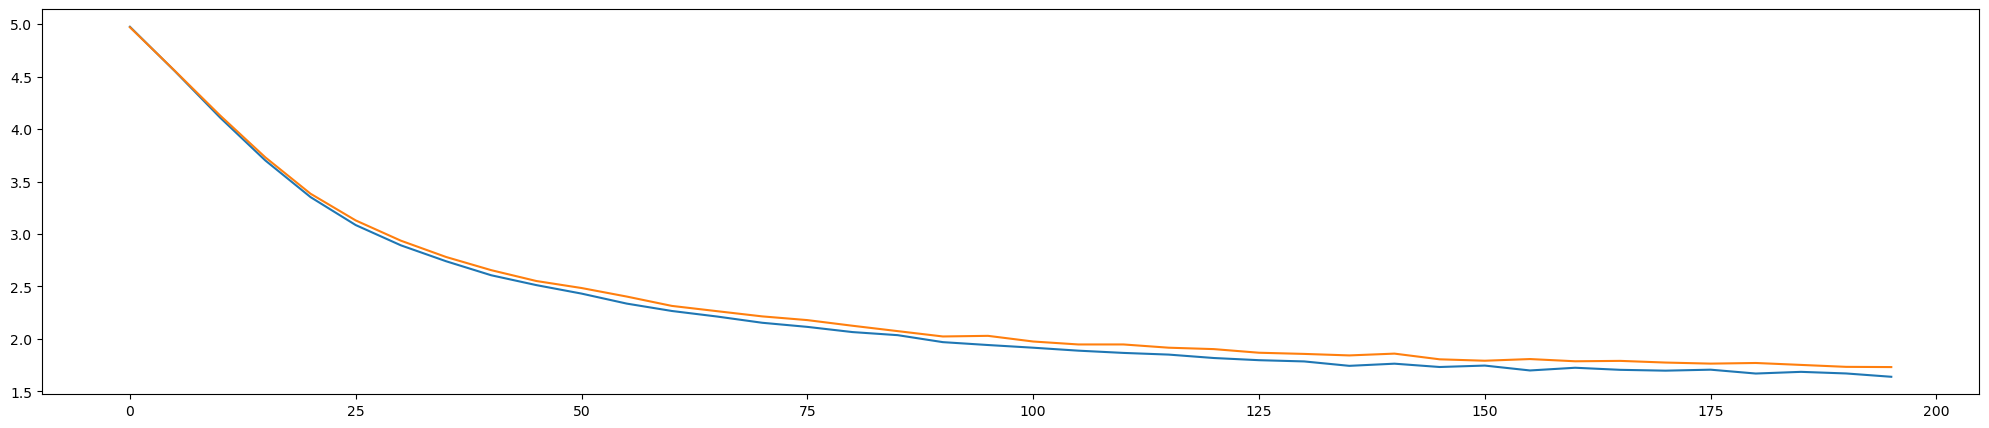

In [365]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 5))

x = [h[0] for h in history]
y = [h[1]['train'] for h in history]
y_val = [h[1]['val'] for h in history]
plt.plot(x, y, label='train')
plt.plot(x, y_val, label='val')

In [366]:
prompt = 'where is Perpignan located?'
prompt = torch.tensor(truncate_sequences([encode(prompt)], seq_len))
idx = torch.ones((1, 1), dtype=torch.long)
print(decode(m.generate(prompt, idx, 100)[0].tolist()))

@$o/$$$$t$$ds$$$$$/$B$a$$$$$$W$$$$$$$+$$$a$$$$Pe$l$$$$o$6É$!$Pl$$mAĀ5$N$u$r#$$$$ñZUte$$us$$ë$'$uiw$$i


In [367]:
torch.save(m.state_dict(), './models/parallel_checkpoints_64_2.pth')